# Design Pattern 10 - Rebalancing (Chapter 3)

## Introduction to Design Pattern

Overview:

Class imbalance often occurs in classification problems (binary, multiclass and multilabel), but can also occur in a regression problems. In regression cases, imbalanced datasets have outliers that are either much higher or lower than the median (e.g. if you are interested in predicting extremes or anomoly detection).

The methods here are focus on datasets that are inherently imbalanced e.g. fraud detection, flagging errors in software logs, precipitiation. <b>Scenarios where datasets lack representation for a specific population or real-world environment can often only be solved by collecting more data.</b>

Solutions for class imbalance:
- Upsampling
- Downsampling
- Weighted classes

Architectures better suited to imbalanced datasets:
- Tree-based models
- Long-Short Term Memory (LSTM) for detecting anomolies in timeseries

<i>Common pitfall</i>  
- Accuracy can often be a misleading metric if data is imbalanced. 
- ROC curves and ROC area under the curve (AUC) score, which are used to assess the performance of a model over all thresholds, is not a useful metric for imbalanced datasets as it treats both classes equally.
- Better metrics (for classification): precision, recall, f-score

Note: metrics should be calculated on unsampled data no how the training data has been classified

<img src="Images/recall_precision_accuracy.png">

## Imports

In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

## Example python implementation

Download fraud kaggle dataset, or it is available here: /data/users/hbrown/fraud_data_kaggle.csv

In [2]:
#!gsutil cp gs://ml-design-patterns/fraud_data_kaggle.csv .

In [3]:
fraud_data = pd.read_csv('/data/users/hbrown/fraud_data_kaggle.csv')
fraud_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
fraud_data.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

### Downsampling 

Downsampling is a solution for handling imbalanced datasets, but changing the underlying dataset, rather than the model. Downsampling reduces the number of examples from the majority class used during model training.

<img src="Images/undersampling.png">

In [5]:
# Drop a few columns we won't use for this demo
fraud_data = fraud_data.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])
fraud_data = pd.get_dummies(fraud_data)

Train model on unsampled data

In [6]:
train_test_split = int(len(fraud_data) * .8)

train_data = fraud_data[:train_test_split]
test_data = fraud_data[train_test_split:]

train_labels = train_data.pop('isFraud')
test_labels = test_data.pop('isFraud')

In [7]:
model = xgb.XGBClassifier()

In [8]:
model.fit(train_data.values, train_labels)

[09:14:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

In [9]:
# Get some test predictions
y_pred = model.predict(test_data.values)

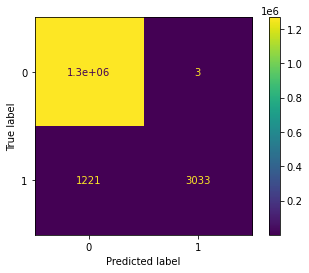

In [10]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(model, test_data, test_labels.values)
plt.show()

In [11]:
print(f'Accuracy = {accuracy_score(test_labels.values, y_pred):.3f}')
print(f'Recall = {recall_score(test_labels.values, y_pred):.3f}')
print(f'Precision = {precision_score(test_labels.values, y_pred):.3f}')

Accuracy = 0.999
Recall = 0.713
Precision = 0.999


Now we downsample the data, to create more even classes and retrain the same model

In [12]:
# Split into separate dataframes
fraud = fraud_data[fraud_data['isFraud'] == 1]
not_fraud = fraud_data[fraud_data['isFraud'] == 0]

# Take a random sample of non-fraud data
# The .005 frac will give us around an 80/20 split of not-fraud/fraud samples
# You can experiment with this value
not_fraud_sample = not_fraud.sample(random_state=2, frac=.005)

In [13]:
# Put the data back together and shuffle
fraud_data_resampled = pd.concat([not_fraud_sample,fraud])
fraud_data_resampled = shuffle(fraud_data_resampled, random_state=2)

In [14]:
# Look at our data balance after downsampling
fraud_data_resampled['isFraud'].value_counts()

0    31772
1     8213
Name: isFraud, dtype: int64

In [15]:
train_test_split = int(len(fraud_data_resampled) * .8)

train_data = fraud_data_resampled[:train_test_split]
test_data = fraud_data_resampled[train_test_split:]

train_labels = train_data.pop('isFraud')
test_labels = test_data.pop('isFraud')

In [16]:
balanced_model = xgb.XGBClassifier()

In [17]:
balanced_model.fit(train_data.values, train_labels)

[09:19:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
# Get some test predictions
y_pred = balanced_model.predict(test_data.values)

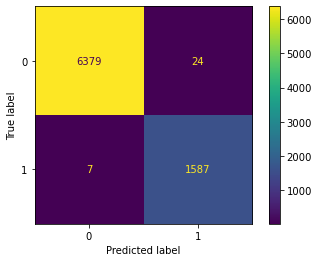

In [19]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(balanced_model, test_data, test_labels.values)
plt.show()

In [20]:
print(f'Accuracy = {accuracy_score(test_labels.values, y_pred):.3f}')
print(f'Recall = {recall_score(test_labels.values, y_pred):.3f}')
print(f'Precision = {precision_score(test_labels.values, y_pred):.3f}')

Accuracy = 0.996
Recall = 0.996
Precision = 0.985


Downsampling can also be combined with the [ensemble pattern](https://github.com/MetOffice/data_science_cop/blob/ml_design_patterns/further_ml_examples/design_patterns/dp7_ch3_ensembles.ipynb), to avoid discarding lots of data from the majority class. e.g. if you have a minority class with 100 samples and a majority class with 1000 samples, you could split the majority class dataset into 10 sets of 100 samples. Combining each of these majority class sets with the 100 minority class samples, you could train 10 seperate models and treat these as an ensemble. 

### Upsampling

With upsampling, we overrepresent the minority class by both replicating minority class examples and generating additional, synthetic examples. This is often done in combination with downsampling of the majority class.

Combining downsampling and upsampling is referred to as synthetic minority over-sampling technique (SMOTE).

<img src="Images/oversampling.png">

### Weighted classes and output bias

Changing the <i>weight</i> our model gives to examples from each class is one way to handle class imbalance. By weighting classes, we tell our model to treat specific label classes with more importance during training, assigning more wait to examples from the minority class. 

The exact weights you assign to each class is something you can experiment with, the suggested example here was:
```Python
minority_class_weight = 1 / (num_minority_examples / total_examples) / 2
majority_class_weight = 1 / (num_majority_examples / total_examples) / 2
```

### Link to explainable AI

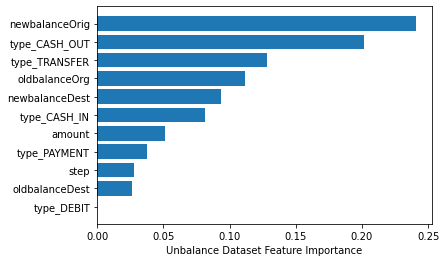

In [21]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(test_data.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Unbalance Dataset Feature Importance")
plt.show()

Text(0.5, 0, 'Balance Dataset Feature Importance')

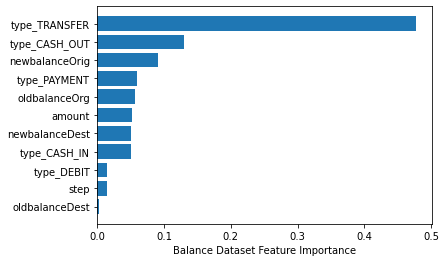

In [22]:
sorted_idx = balanced_model.feature_importances_.argsort()
plt.barh(test_data.columns[sorted_idx], balanced_model.feature_importances_[sorted_idx])
plt.xlabel("Balance Dataset Feature Importance")

## Real world examples


Try to include some actual/possible examples of where this DP could be used in a weather and climate context.

- Extremes modelling 
- Anomoly detection 
- Precipitation rain or no rain modelling 